<h3 align='center'><b>PROJECT TITLE - Building a Restaurant Recommendation System</b></h3>


**Team Name - Ensemblers**

**Team Members** -<br>
*   Ishani Bari
*   Preetpal Singh
*   Rampunit Kumar 
*   Umang Agarwal


**PROBLEM STATEMENT** - <br>
Create a recommendation system for restaurants using collaborative filtering (CF).


**DATASET** -<br>
We will be using the Yelp Dataset for this. The yelp dataset contains 5 JSON files -
*   **business.json** which contains business data including location data, attributes, and categories.
*   **review.json** which contains full review text data including the user_id that wrote the review and the business_id the review is written for.
*   **user.json** that has user data including the user's friend mapping and all the metadata associated with the user.
*   **checkin.json** that stores checkins on a business.
*   **tip.json** that contains tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.



**OUR APPROACH TO THIS PROBLEM STATEMENT**-<br>
*   First, we have unzip the yelp dataset's .tar file and stored the extracted JSON files in a google drive.
*   Then we have created a database **'restaurants.db'** which stores the tables for review, user, checkin and tip data in the respective tables.
*   Pre-processing the business data - read the business.json file as dataframe, kept only the business of category restaurant or food and preprocessed that dataset.
*   Pushed the cleaned business dataframe into restaurants.db
*   Fetched the required data from 'restaurants.db' and performed EDA on datasets 'user' and 'review'.
*   Joined the business table and reviews tables on 'business_id' attribute and stored in a dataframe 'business_reviews'.
*   Joined users table to 'business_reviews' on 'user_id'.
*   Created a database of item-item similarities.
*   CF-based Recommender system using Stochastic Gradient Descent.
*   Evaluation and recommending restaurants to users.

In [ ]:
# Importing the required libraries
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from prettytable import PrettyTable
import warnings
from datetime import datetime as dt
import sqlite3
from sqlalchemy import create_engine
from sklearn.impute import SimpleImputer
from keras.regularizers import l2
import tensorflow as tf 
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
from tensorflow.keras import backend as K
warnings.filterwarnings('ignore')

In [ ]:
# # downloading the json files from gdrive
# # !gdown --folder https://drive.google.com/drive/folders/1yIEP45IIfJrJE1OrWIMJfU2Rq6pvDTvo

In [ ]:
# # removing unnecessary files
# files =['/content/DS1 Project'+'/'+path for path in  os.listdir('/content/DS1 Project')]
# for file in files:
#   if file.endswith('.json'):
#     continue
#   else:
#     os.remove(file)

### **Creating the database 'restaurants.db' and storing data as tables in it.**
This file contains the following tables - 

1) User table **(Name : user_sql)** </br>
2) review table **(Name : review_sql)** </br>
3) tips table **(Name : tips_sql)**</br>
4) checkin table **(Name : checkin_sql)**</br>
5) Item item cosine similarity **(Name : item_item_sql)**</br>

In [ ]:
chunk_size = 500000
batch_no = 1

In [ ]:
#set this to true if you want to create a db again
create_db = False

In [ ]:
if create_db: 
  restaurants = create_engine('sqlite:///restaurats.db')

In [ ]:
if create_db:  
  for chunk in pd.read_json(r"C:\Users\UMANG\DS1 PROJECT\yelp_academic_dataset_user.json" , lines = True , chunksize=chunk_size):
      chunk.to_sql('user_sql',restaurants , if_exists = 'append')
      batch_no = batch_no+1
      print("Batch No : {}".format(batch_no))

In [ ]:
if create_db:
  for chunk in pd.read_json(r"C:\Users\UMANG\DS1 PROJECT\yelp_academic_dataset_review.json" , lines = True , chunksize=chunk_size):
      chunk.to_sql('review_sql',restaurants , if_exists = 'append')
      batch_no = batch_no+1
      print("Batch No : {}".format(batch_no))

In [ ]:
if create_db:
  for chunk in pd.read_json(r"C:\Users\UMANG\DS1 PROJECT\yelp_academic_dataset_tip.json" , lines = True , chunksize=chunk_size):
      chunk.to_sql('tips_sql',restaurants , if_exists = 'append')
      batch_no = batch_no+1
      print("Batch No : {}".format(batch_no))

In [ ]:
if create_db: 
  for chunk in pd.read_json(r"C:\Users\UMANG\DS1 PROJECT\yelp_academic_dataset_checkin.json" , lines = True , chunksize=chunk_size):
      chunk.to_sql('checkin_sql',restaurants , if_exists = 'append')
      batch_no = batch_no+1
      print("Batch No : {}".format(batch_no))

In [ ]:
# # downloading db object from google drive
!gdown 1s2QdsvUMDpalm3kvRfQwX-NJtelVGY_0

Downloading...
From: https://drive.google.com/uc?id=1s2QdsvUMDpalm3kvRfQwX-NJtelVGY_0
To: /content/restaurants.db
100% 9.18G/9.18G [01:00<00:00, 151MB/s]


In [ ]:
if not create_db:
  conn = sqlite3.connect("restaurants.db")
  cursor = conn.cursor()

### **Pre processing business df by doing following steps:**


1.   Unpacking the json into columns.
2.   Dropping null values except for attributes.
3.   Unpacking nested json columns.
4.   Merging the nested dataframes.
5.   One hot encoding the categorical columns which we get from nested dfs
6.   Converting daily hours to individual columns


#### 1. Unpacking json into columns

In [ ]:
# reading the business.json file
with open(r"C:\Users\UMANG\DS1 PROJECT\yelp_academic_dataset_business.json", 'rb') as f:
    file1 = f.readlines()

In [ ]:
file1 = [json.loads(file.strip()) for file in file1]

In [ ]:
# Reading as dataframe
business_df = pd.json_normalize(file1, sep='_')
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,attributes_AcceptsInsurance,attributes_BestNights,attributes_BYOB,attributes_Corkage,attributes_BYOBCorkage,attributes_HairSpecializesIn,attributes_Open24Hours,attributes_RestaurantsCounterService,attributes_AgesAllowed,attributes_DietaryRestrictions
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Filtering only the businesses categories which contain restaurants.

In [ ]:
# we only want the restaurants from the dataframe, filtering them out from the vanilla business df

# create a mask for restaurants
mask_restaurants = business_df['categories'].str.contains('Restaurants')

# create a mask for food
mask_food = business_df['categories'].str.contains('Food')

# apply both masks
business_df = business_df[mask_restaurants & mask_food]

# number of businesses that have food and restaurant in their category
print("business which are restaurants: ", business_df['categories'].shape[0])

business which are restaurants:  21057


In [ ]:
#checking the sparsity of categories containing food or restaurant as keywords
business_df['categories'].str.get_dummies(',').sum(axis=0)

 Acai Bowls          148
 Accessories           5
 Accountants           1
 Active Life          52
 Acupuncture           1
                    ... 
Wine Tasting Room      2
Wine Tours             1
Wineries              13
Wraps                 16
Yoga                   3
Length: 835, dtype: int64

In [ ]:
#dropping the categories columns, as it's very sparse if we one hot encode it and dosen't provides much info
business_df.drop('categories', axis=1, inplace=True)

In [ ]:
business_df.drop(['attributes', 'hours'], inplace=True, axis=1)

In [ ]:
day_col = [hour for hour in business_df.columns if hour.startswith('hour')]
attributes_col = [attr for attr in business_df.columns if attr.startswith('attributes')]

In [ ]:
# creating dataframe after dropping attributes and hours cols
business_df_1 = business_df.drop(day_col+attributes_col, axis=1)

#### 2 Dropping null values form business df except for attributes


#### 1.   Replacing null values in attributes by 0 and converting true false to 1 and 0



In [ ]:
hours_attr = business_df[day_col + attributes_col].fillna(0).replace(['True', 'False', 'None'], [1, 0, 0])

In [ ]:
#converting true false values to one hot encoded values
for col in attributes_col:
    try:
        hours_attr[col] = hours_attr[col].astype(int).fillna(0)
    except Exception as e:
        continue

In [ ]:
# finding days which are having 0 values lesser then 0.2% of the observations
[col for col in day_col if sum(hours_attr[col] == 0) < hours_attr.shape[0] / 500]

[]

In [ ]:
#finding attributes which are less then 1% and dropping them 
mapping = hours_attr[attributes_col].sum(axis=0) < hours_attr.shape[0] * 0.01
for i in mapping.iteritems():
  if i[1] == True:
    hours_attr.drop(i[0], axis=1, inplace=True)
    attributes_col.remove(i[0])

In [ ]:
#checking for dropped attributes
hours_attr[attributes_col].sum(axis=0) < hours_attr.shape[0] * 0.01

attributes_BusinessAcceptsCreditCards    False
attributes_BikeParking                   False
attributes_RestaurantsPriceRange2        False
attributes_RestaurantsTakeOut            False
attributes_RestaurantsDelivery           False
attributes_Caters                        False
attributes_WheelchairAccessible          False
attributes_HappyHour                     False
attributes_OutdoorSeating                False
attributes_HasTV                         False
attributes_RestaurantsReservations       False
attributes_DogsAllowed                   False
attributes_GoodForKids                   False
attributes_RestaurantsTableService       False
attributes_RestaurantsGoodForGroups      False
attributes_DriveThru                     False
attributes_BYOB                          False
attributes_Corkage                       False
dtype: bool

#### 2. dropping null values from business df except for attributes and hours

In [ ]:
#checking for null values
business_df_1.isna().sum()

business_id     0
name            0
address         0
city            0
state           0
postal_code     0
latitude        0
longitude       0
stars           0
review_count    0
is_open         0
dtype: int64

In [ ]:
print("Shape of final_Business_df shape : {}".format(business_df_1.shape))

Shape of final_Business_df shape : (21057, 11)


In [ ]:
# concatenating final business df with hours feature
business_df_new = business_df_1.join(hours_attr, how='inner')
business_df_new.shape

(21057, 50)

In [ ]:
print(f"Null values in the dataframe : {sum(business_df_new.isna().sum())}")

Null values in the dataframe : 0


In [ ]:
#checking for data types 
business_df_new.dtypes

business_id                               object
name                                      object
address                                   object
city                                      object
state                                     object
postal_code                               object
latitude                                 float64
longitude                                float64
stars                                    float64
review_count                               int64
is_open                                    int64
hours_Monday                              object
hours_Tuesday                             object
hours_Wednesday                           object
hours_Thursday                            object
hours_Friday                              object
hours_Saturday                            object
hours_Sunday                              object
attributes_BusinessAcceptsCreditCards      int32
attributes_BikeParking                     int32
attributes_Restauran

In [ ]:
# filtering on all object type attributes for further preprocessing
attr_object_dtype = business_df_new[attributes_col].dtypes[business_df_new[attributes_col].dtypes == 'object'].index.values.tolist()
attr_object_dtype

['attributes_WiFi',
 'attributes_BusinessParking',
 'attributes_Alcohol',
 'attributes_RestaurantsAttire',
 'attributes_Ambience',
 'attributes_NoiseLevel',
 'attributes_GoodForMeal',
 'attributes_Smoking',
 'attributes_Music',
 'attributes_BestNights',
 'attributes_BYOBCorkage',
 'attributes_HairSpecializesIn',
 'attributes_AgesAllowed',
 'attributes_DietaryRestrictions']

In [ ]:
# dropping columns having  missing values greater than 90%
cols_to_drop = []
rem_attr_object_dtype = attr_object_dtype[:]
dict_cols = []
for col in attr_object_dtype:
  if business_df_new[col].value_counts()[0] > (business_df_new.shape[0] * 0.9):
    cols_to_drop.append(col)
    rem_attr_object_dtype.remove(col)
  else:
    for idx in business_df_new[col].value_counts().index:
      if type(idx) == str and idx.startswith('{'):
        dict_cols.append(col)
        rem_attr_object_dtype.remove(col)
        break

In [ ]:
cols_to_drop

['attributes_Smoking',
 'attributes_Music',
 'attributes_BestNights',
 'attributes_BYOBCorkage',
 'attributes_HairSpecializesIn',
 'attributes_AgesAllowed',
 'attributes_DietaryRestrictions']

In [ ]:
# columns containing dictionary as string or contain multivalue.
dict_cols

['attributes_BusinessParking', 'attributes_Ambience', 'attributes_GoodForMeal']

In [ ]:
# dropping the above listed columns with missing values > 90%
business_df_new.drop(cols_to_drop, inplace=True, axis=1)

#### 3. Unpacking nested json columns:


1.   'attributes_BusinessParking'
2.   'attributes_Ambience'
3.   'attributes_GoodForMeal'

In [ ]:
#Unpacking nested json values
nested_dfs = []
for col in dict_cols:
  idx_dict = business_df_new[col][business_df_new[col] != 0].index
  idx_values = business_df_new[col][business_df_new[col] != 0].values.tolist()
  idx_values = list(map(eval, idx_values))
  df = pd.DataFrame(idx_values, index=idx_dict)
  df.columns = [col + '_' + name for name in df.columns]
  nested_dfs.append(df.fillna(0).astype(int))

In [ ]:
# checking for null values in nested dataframes
nested_dfs[0].isna().sum(), nested_dfs[1].isna().sum(), nested_dfs[2].isna().sum()

(attributes_BusinessParking_garage       0
 attributes_BusinessParking_street       0
 attributes_BusinessParking_validated    0
 attributes_BusinessParking_lot          0
 attributes_BusinessParking_valet        0
 dtype: int64,
 attributes_Ambience_touristy    0
 attributes_Ambience_hipster     0
 attributes_Ambience_romantic    0
 attributes_Ambience_divey       0
 attributes_Ambience_intimate    0
 attributes_Ambience_trendy      0
 attributes_Ambience_upscale     0
 attributes_Ambience_classy      0
 attributes_Ambience_casual      0
 dtype: int64,
 attributes_GoodForMeal_dessert      0
 attributes_GoodForMeal_latenight    0
 attributes_GoodForMeal_lunch        0
 attributes_GoodForMeal_dinner       0
 attributes_GoodForMeal_brunch       0
 attributes_GoodForMeal_breakfast    0
 dtype: int64)

In [ ]:
#Dropping original nested columns
business_df_new.drop(dict_cols, axis=1, inplace=True)

#### 4. Merging the nested dfs

In [ ]:
final_business_df = pd.concat([business_df_new]+nested_dfs, axis=1)
final_business_df.fillna(0, inplace=True)
final_business_df.shape
final_business_df.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'hours_Monday', 'hours_Tuesday', 'hours_Wednesday', 'hours_Thursday',
       'hours_Friday', 'hours_Saturday', 'hours_Sunday',
       'attributes_BusinessAcceptsCreditCards', 'attributes_BikeParking',
       'attributes_RestaurantsPriceRange2', 'attributes_RestaurantsTakeOut',
       'attributes_RestaurantsDelivery', 'attributes_Caters',
       'attributes_WiFi', 'attributes_WheelchairAccessible',
       'attributes_HappyHour', 'attributes_OutdoorSeating', 'attributes_HasTV',
       'attributes_RestaurantsReservations', 'attributes_DogsAllowed',
       'attributes_Alcohol', 'attributes_GoodForKids',
       'attributes_RestaurantsAttire', 'attributes_RestaurantsTableService',
       'attributes_RestaurantsGoodForGroups', 'attributes_DriveThru',
       'attributes_NoiseLevel', 'attributes_BYOB', 'attributes_Corkage',
       'attributes_Busine

In [ ]:
print("Shape of Business_DF : {}".format(final_business_df.shape))

Shape of Business_DF : (21057, 60)


#### 5. One hot encoding the columns which we get from nested dfs

In [ ]:
# one hot encoding nested json values
for col in rem_attr_object_dtype:
  df = pd.get_dummies(final_business_df[col])
  final_business_df.drop(col, axis=1, inplace=True)
  df = df[df.columns[1:]]
  df.columns = [col + name for name in df.columns]
  final_business_df = final_business_df.join(df)

In [ ]:
final_business_df.shape

(21057, 82)

In [ ]:
final_business_df.reset_index(drop=True, inplace=True)

#### 6. Converting daily hours to individual columns

##### Handling missing values and dropping business which are having all days hours value as 0

In [ ]:
final_business_df[day_col]

,hours_Monday,hours_Tuesday,hours_Wednesday,hours_Thursday,hours_Friday,hours_Saturday,hours_Sunday
0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0
1,0:0-0:0,6:0-22:0,6:0-22:0,6:0-22:0,9:0-0:0,9:0-22:0,8:0-22:0
2,0:0-0:0,6:0-21:0,6:0-21:0,6:0-16:0,6:0-16:0,6:0-17:0,6:0-21:0
3,11:0-14:0,11:0-14:0,11:0-14:0,11:0-14:0,11:0-14:0,5:0-10:0,15:0-18:0
4,10:0-18:0,10:0-20:0,10:0-20:0,10:0-20:0,10:0-20:0,10:0-20:0,0
...,...,...,...,...,...,...,...
21052,9:0-19:30,9:0-19:30,9:0-19:30,9:0-19:30,9:0-17:0,11:0-17:0,11:0-19:30
21053,0:0-0:0,16:0-21:0,16:0-21:0,16:0-21:0,16:0-22:0,15:0-22:0,12:0-21:0
21054,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0
21055,0:0-0:0,0:0-17:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0


In [ ]:
#looking for rows with missing days
missing_days = final_business_df.index[np.all(final_business_df[day_col] == 0, axis=1)]
final_business_df[day_col].iloc[missing_days, :]

,hours_Monday,hours_Tuesday,hours_Wednesday,hours_Thursday,hours_Friday,hours_Saturday,hours_Sunday
33,0,0,0,0,0,0,0
45,0,0,0,0,0,0,0
46,0,0,0,0,0,0,0
47,0,0,0,0,0,0,0
50,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
21024,0,0,0,0,0,0,0
21025,0,0,0,0,0,0,0
21044,0,0,0,0,0,0,0
21045,0,0,0,0,0,0,0


In [ ]:
#dropping rows where the restaurant remained closed for all 7 days 
final_business_df.drop(missing_days, axis=0, inplace=True)

In [ ]:
#reset index of dataframe
final_business_df.reset_index(inplace=True, drop=True)
final_business_df.shape

(18939, 82)

In [ ]:
# imputing the missing values with the most frequent values using simple imputer along rows
imputer = SimpleImputer(missing_values=0, strategy='most_frequent')
X = imputer.fit_transform(final_business_df[day_col].T).T
X.shape

(18939, 7)

In [ ]:
final_business_df[day_col] = X

In [ ]:
# checking for null values
final_business_df[day_col].isna().sum()

hours_Monday       0
hours_Tuesday      0
hours_Wednesday    0
hours_Thursday     0
hours_Friday       0
hours_Saturday     0
hours_Sunday       0
dtype: int64

Some of the shops are having working hours such as 0:0-0:0, and 0:0-0:0 on the next corresponding day too, indicating that these shops are probably an online business. Where as 0 indicates the shop was not open at all.

#### Converting hours interval to open and closing timestamp columns

In [ ]:
for day in day_col:
  df = pd.DataFrame(final_business_df[day].str.split('-').values)
  df = pd.DataFrame(df[0].tolist(), columns = [day+'_opening', day+ '_closing'])
  final_business_df.drop(day, axis=1, inplace=True)
  final_business_df = pd.concat([final_business_df, df], axis=1)

In [ ]:
final_business_df.shape

(18939, 89)

In [ ]:
day_col_new = []
for day in day_col:
  day_col_new.extend([day+'_opening', day+ '_closing'])
day_col_new

['hours_Monday_opening',
 'hours_Monday_closing',
 'hours_Tuesday_opening',
 'hours_Tuesday_closing',
 'hours_Wednesday_opening',
 'hours_Wednesday_closing',
 'hours_Thursday_opening',
 'hours_Thursday_closing',
 'hours_Friday_opening',
 'hours_Friday_closing',
 'hours_Saturday_opening',
 'hours_Saturday_closing',
 'hours_Sunday_opening',
 'hours_Sunday_closing']

In [ ]:
for col in day_col_new:
# converting hours columns to datetime object
 final_business_df[col] = pd.to_datetime(final_business_df[col], format='%H:%M')

In [ ]:
final_business_df[day_col_new]

,hours_Monday_opening,hours_Monday_closing,hours_Tuesday_opening,hours_Tuesday_closing,hours_Wednesday_opening,hours_Wednesday_closing,hours_Thursday_opening,hours_Thursday_closing,hours_Friday_opening,hours_Friday_closing,hours_Saturday_opening,hours_Saturday_closing,hours_Sunday_opening,hours_Sunday_closing
0,1900-01-01 07:00:00,1900-01-01 20:00:00,1900-01-01 07:00:00,1900-01-01 20:00:00,1900-01-01 07:00:00,1900-01-01 20:00:00,1900-01-01 07:00:00,1900-01-01 20:00:00,1900-01-01 07:00:00,1900-01-01 21:00:00,1900-01-01 07:00:00,1900-01-01 21:00:00,1900-01-01 07:00:00,1900-01-01 21:00:00
1,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 09:00:00,1900-01-01 00:00:00,1900-01-01 09:00:00,1900-01-01 22:00:00,1900-01-01 08:00:00,1900-01-01 22:00:00
2,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 06:00:00,1900-01-01 21:00:00,1900-01-01 06:00:00,1900-01-01 21:00:00,1900-01-01 06:00:00,1900-01-01 16:00:00,1900-01-01 06:00:00,1900-01-01 16:00:00,1900-01-01 06:00:00,1900-01-01 17:00:00,1900-01-01 06:00:00,1900-01-01 21:00:00
3,1900-01-01 11:00:00,1900-01-01 14:00:00,1900-01-01 11:00:00,1900-01-01 14:00:00,1900-01-01 11:00:00,1900-01-01 14:00:00,1900-01-01 11:00:00,1900-01-01 14:00:00,1900-01-01 11:00:00,1900-01-01 14:00:00,1900-01-01 05:00:00,1900-01-01 10:00:00,1900-01-01 15:00:00,1900-01-01 18:00:00
4,1900-01-01 10:00:00,1900-01-01 18:00:00,1900-01-01 10:00:00,1900-01-01 20:00:00,1900-01-01 10:00:00,1900-01-01 20:00:00,1900-01-01 10:00:00,1900-01-01 20:00:00,1900-01-01 10:00:00,1900-01-01 20:00:00,1900-01-01 10:00:00,1900-01-01 20:00:00,1900-01-01 10:00:00,1900-01-01 20:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18934,1900-01-01 09:00:00,1900-01-01 19:30:00,1900-01-01 09:00:00,1900-01-01 19:30:00,1900-01-01 09:00:00,1900-01-01 19:30:00,1900-01-01 09:00:00,1900-01-01 19:30:00,1900-01-01 09:00:00,1900-01-01 17:00:00,1900-01-01 11:00:00,1900-01-01 17:00:00,1900-01-01 11:00:00,1900-01-01 19:30:00
18935,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 16:00:00,1900-01-01 21:00:00,1900-01-01 16:00:00,1900-01-01 21:00:00,1900-01-01 16:00:00,1900-01-01 21:00:00,1900-01-01 16:00:00,1900-01-01 22:00:00,1900-01-01 15:00:00,1900-01-01 22:00:00,1900-01-01 12:00:00,1900-01-01 21:00:00
18936,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00
18937,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 17:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00


In [ ]:
print("Shape of final_Business_Df : {}".format(final_business_df.shape))

Shape of final_Business_Df : (18939, 89)


In [ ]:
# Pushing the final_business_df to database
if create_db:
    final_business_df.to_sql('business_sql', conn, if_exists='replace', index=False)

In [ ]:
# import shutil

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %mkdir /content/drive/My Drive/Colab Notebook/

In [ ]:
#checking for database connectivity and business_df 
cursor = conn.cursor()
# cursor.execute('''PRAGMA table_info(business_sql)''').fetchall()

In [ ]:
final_business_df.to_pickle("Final_business_df.pkl")

## Performing EDA
### Business Table

In [ ]:
# selecting all columns from business table
colname_query = '''
        SELECT *
        FROM business_sql
        LIMIT 1
            '''

In [ ]:
# storing the result of the query in a dataframe
business_df_columns = pd.DataFrame(cursor.execute(colname_query).description)[0].values

In [ ]:
# filtering different encoded features based on the parent feature and storing in respective parent list defined below
key_words = ['Parking','Ambience','GoodForMeal','WiFi','Alcohol','Attire','NoiseLevel']
parking_ , ambience , gfm , wifi , alcohol , attire_ , NL_ = [], [], [], [], [], [], []
Misc = []

for i in business_df_columns:
    if key_words[0] in i:
        parking_.append(i)
    elif key_words[1] in i:
        ambience.append(i)
    elif key_words[2] in i:
        gfm.append(i)
    elif key_words[3] in i:
        wifi.append(i)
    elif key_words[4] in i:
        alcohol.append(i)
    elif key_words[5] in i:
        attire_.append(i)
    elif key_words[6] in i:
        NL_.append(i)
    else:
        Misc.append(i)
    

In [ ]:
#Querying for Parking facilities for different restaurants
query_parking_stars = '''
        SELECT stars ,attributes_BikeParking , attributes_BusinessParking_garage,attributes_BusinessParking_street,
                attributes_BusinessParking_validated,attributes_BusinessParking_lot,attributes_BusinessParking_valet
        FROM business_sql
    '''

parking_star = cursor.execute(query_parking_stars).fetchall()

In [ ]:
#Storing the result in a dataframe parking_star_df
parking_star_df = pd.DataFrame(parking_star , columns = ['stars' ,'attributes_BikeParking','attributes_BusinessParking_garage','attributes_BusinessParking_street',
                'attributes_BusinessParking_validated','attributes_BusinessParking_lot','attributes_BusinessParking_valet'])

In [ ]:
#Plotting the most commonly used parking 
parking_star_df.groupby(by = 'stars').sum().iloc[-3:,:].sum().sort_values().plot(kind = 'barh' , color = 'red' , alpha = 0.5 , linewidth = 10)
plt.xlabel("Number of restaurants")
plt.ylabel("Parking Facility")
plt.title("Most common parking Facility at Top Rated Restaurants")

* Here it can be observed that most of the top rated restaurants have a private parking lot

In [ ]:
# query for categories of ambience with their respective ratings in stars 
query_amb_stars = '''
        SELECT stars ,attributes_Ambience_touristy,attributes_Ambience_hipster,attributes_Ambience_romantic,
               attributes_Ambience_divey,attributes_Ambience_intimate,attributes_Ambience_trendy,attributes_Ambience_upscale,
               attributes_Ambience_classy,attributes_Ambience_casual
        FROM business_sql
    '''

amb_star = cursor.execute(query_amb_stars).fetchall()

In [ ]:
# storing the data in a dataframe 
amb_star_df = pd.DataFrame(amb_star , columns = ['stars' ,'attributes_Ambience_touristy','attributes_Ambience_hipster','attributes_Ambience_romantic',
               'attributes_Ambience_divey','attributes_Ambience_intimate','attributes_Ambience_trendy','attributes_Ambience_upscale',
               'attributes_Ambience_classy','attributes_Ambience_casual'])

Text(0.5, 1.0, 'Most commonly Preferred Ambience at Top Rated Restaurants')

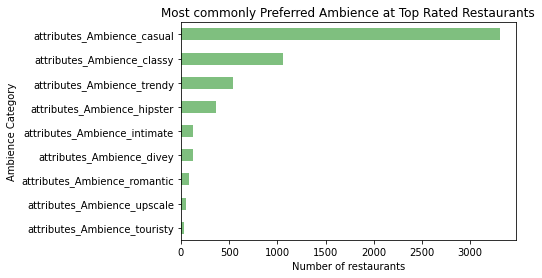

In [ ]:
#Plotting the most commonly prefered ambience 
amb_star_df.groupby(by = 'stars').sum().iloc[-3:,:].sum().sort_values().plot(kind = 'barh' , color = 'g' , alpha = 0.5 , linewidth = 10)
plt.xlabel("Number of restaurants")
plt.ylabel("Ambience Category")
plt.title("Most commonly Preferred Ambience at Top Rated Restaurants")

* Here it can be observed that people like to visit restaurants with a **casual / classy ambience** more often

In [ ]:
# query for categories of GoodForMeal with their respective ratings in stars 
query_gfm_stars = '''
        SELECT stars ,attributes_GoodForMeal_dessert,attributes_GoodForMeal_latenight,attributes_GoodForMeal_lunch,
               attributes_GoodForMeal_dinner,attributes_GoodForMeal_brunch,attributes_GoodForMeal_breakfast
        FROM business_sql
    '''

gfm_star = cursor.execute(query_gfm_stars).fetchall()

In [ ]:
# storing the data in a dataframe 
gfm_star_df = pd.DataFrame(gfm_star , columns = ['stars' ,'attributes_GoodForMeal_dessert','attributes_GoodForMeal_latenight','attributes_GoodForMeal_lunch',
                                                   'attributes_GoodForMeal_dinner','attributes_GoodForMeal_brunch','attributes_GoodForMeal_breakfast'])

Text(0.5, 1.0, 'Most commonly Preferred Meal Category at Top Rated Restaurants')

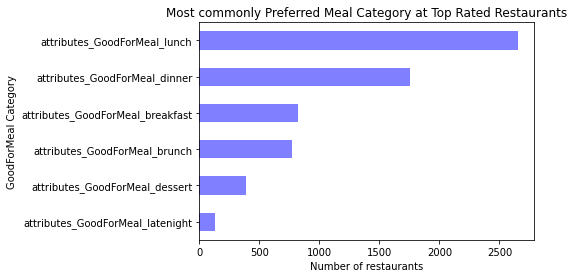

In [ ]:
#Plotting the most commonly prefered Meals 
gfm_star_df.groupby(by = 'stars').sum().iloc[-3:,:].sum().sort_values().plot(kind = 'barh' , color = 'b' , alpha = 0.5 , linewidth = 10)
plt.xlabel("Number of restaurants")
plt.ylabel("GoodForMeal Category")
plt.title("Most commonly Preferred Meal Category at Top Rated Restaurants")

* It can be observed that users like to eat lunch or dinner at a restaurant more than breakfast 

In [ ]:
# querying for distribution of restaurant ratings

query_rating = '''

        SELECT DISTINCT business_id , stars
        FROM business_sql

'''

ratings_ = cursor.execute(query_rating).fetchall()

In [ ]:
# Storing the restaurant rating for various business ids in a dataframe
ratings_df = pd.DataFrame(ratings_ , columns = ['Business_id','Stars'])

Text(0.5, 1.0, 'Distribution of restaurant ratings')

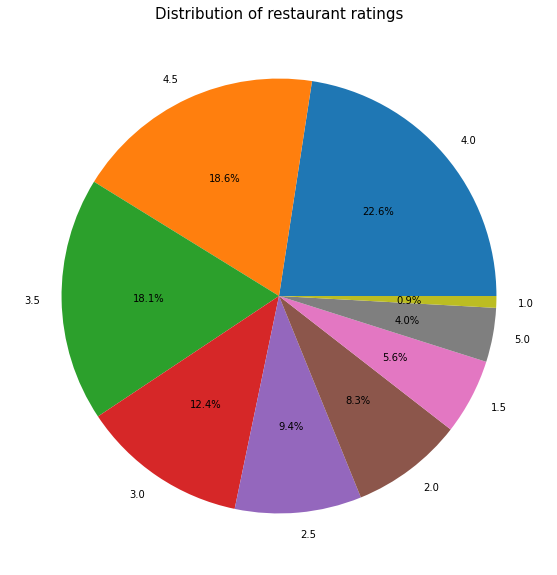

In [ ]:
# plotting the distribution of ratings 
label = ratings_df['Stars'].value_counts().apply(lambda x : (x/len(ratings_df))*100).sort_values(ascending = False).index.tolist()
val = ratings_df['Stars'].value_counts().apply(lambda x : (x/len(ratings_df))*100).sort_values(ascending = False).values.tolist()

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)

plt.figure(figsize = (10,10))
plt.pie(val , labels = label , autopct=lambda pct: func(pct, val) )
plt.title("Distribution of restaurant ratings",fontsize = 15)

* The users have generously rated above 4.0 more than 45% of the times

In [ ]:
#Querying for the features to get most popular restaurant based on number of reviews it receives 

query_x = '''
        SELECT DISTINCT name , review_count , city , stars
        FROM business_sql
        
        '''

name_ = cursor.execute(query_x).fetchall()

In [ ]:
# storing the result in a dataframe
name_df = pd.DataFrame(name_ , columns = ['name','review_count', 'city','stars'])
name_df.head()

,name,review_count,city,stars
0,St Honore Pastries,80,Philadelphia,4.0
1,Sonic Drive-In,6,Ashland City,2.0
2,Sonic Drive-In,10,Nashville,1.5
3,Vietnamese Food Truck,10,Tampa Bay,4.0
4,Zio's Italian Market,100,Largo,4.5


(-1.1060934019937385,
 1.1002901619997019,
 -1.1059638122715625,
 1.108048477986156)

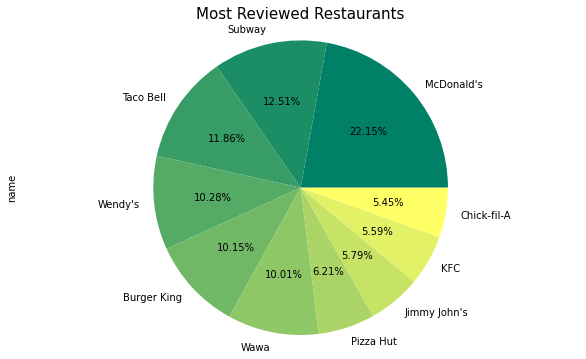

In [ ]:
# PLotting a pie chart to visualise the restaurany with most number of reviews
name_df[['name', 'review_count', 'city', 'stars']].sort_values(ascending=False, by="review_count")[0:10]
name_df['name'].value_counts().sort_values(ascending=False).head(10)
name_df['name'].value_counts().sort_values(ascending=False).head(10).plot(kind='pie',figsize=(10,6),fontsize = 10,autopct='%1.2f%%' , cmap = 'summer' , )
plt.title("Most Reviewed Restaurants",fontsize = 15)
plt.axis('equal')

* McDonalds , Subway , Taco Bell and Wendy's are favourite food joints for most users

### User Table

In [ ]:
# Print number of rows in the data

#Query

query_1 = '''
    SELECT COUNT(*) AS NUM
    FROM user_sql
    '''

num_rows = cursor.execute(query_1).fetchall()
print("Number of rows in User DataBase : {}".format(num_rows[0][0]))

Number of rows in User DataBase : 1987897


In [ ]:
# Number of unique users in the DataBase
query_2 = '''
        SELECT DISTINCT user_id , review_count
        FROM user_sql
        '''

user_id = cursor.execute(query_2).fetchall()

In [ ]:
# Saving the result of query in user_df DataFrame
user_df = pd.DataFrame(user_id , columns = ['user_id' , 'review_count'])
print("Number of Unique Users : {}".format(len(user_df['user_id'].unique())))

Number of Unique Users : 1987897


In [ ]:
# User lifecycle 

query_3 = '''
    SELECT DISTINCT user_id , yelping_since
    FROM user_sql
'''

userlife = cursor.execute(query_3).fetchall()

In [ ]:
# saving the result of the query in dataframe 
user_lifecycle_df = pd.DataFrame(userlife , columns = ['user_id' , 'Yelping_since'])

In [ ]:
# type casting the yelping since column to time stamp
user_lifecycle_df['Yelping_since'] = pd.to_datetime(user_lifecycle_df['Yelping_since'])
user_lifecycle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987897 entries, 0 to 1987896
Data columns (total 2 columns):
 #   Column         Dtype         
---  ------         -----         
 0   user_id        object        
 1   Yelping_since  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 30.3+ MB


In [ ]:
# creating a new feature {'User_life' : Number of days since the user joined Yelp }
user_lifecycle_df['User_life'] = user_lifecycle_df['Yelping_since'].apply(lambda x : (date.today() - x.date()).days)

In [ ]:
# number of friends each user has 

query_4 = '''
        SELECT DISTINCT user_id , LENGTH(friends)
        FROM user_sql
'''

count_friend = cursor.execute(query_4).fetchall()

In [ ]:
# Saving the result in a dataframe
friend_count = pd.DataFrame(count_friend , columns = ['user_id' , 'Number_of_friends'])

In [ ]:
# number of useful , funny , cool votes per user 

query_5 = '''
        SELECT DISTINCT user_id , useful , funny , cool 
        FROM user_sql
'''

votes = cursor.execute(query_5).fetchall()

In [ ]:
# saving the result in a dataframe
votes_df = pd.DataFrame(votes , columns = ['user_id' , 'useful' , 'funny' , 'cool'])

In [ ]:
# total compliments received by the user 

query_6 = '''
        SELECT DISTINCT user_id,compliment_hot + compliment_more + compliment_profile + compliment_cute + compliment_list + compliment_note + compliment_plain + compliment_cool + compliment_funny + compliment_writer AS Total , compliment_photos
        FROM user_sql
'''

comp = cursor.execute(query_6).fetchall()

In [ ]:
# saving the result in a dataframe
comp_df = pd.DataFrame(comp , columns = ['user_id' ,'TOTAL', 'compliment_photos'])

In [ ]:
# arranging the data in a Pretty Table for better visualisation 
AVG_Table = PrettyTable(["Feature" , "Average" , "Units"])

AVG_Table.add_row(["Review_Count" , int(np.round(user_df['review_count'].mean())) , 'No.'])
AVG_Table.add_row(["User_Life" , int(np.round(user_lifecycle_df['User_life'].mean())) , 'Days'])
AVG_Table.add_row(["Number_Of_Friends" , int(np.round(friend_count['Number_of_friends'].mean())) , 'No.'])
AVG_Table.add_row(["Useful_Votes" , int(np.round(votes_df['useful'].mean())) , 'Votes'])
AVG_Table.add_row(["Funny_Votes" , int(np.round(votes_df['funny'].mean())) , 'Votes'])
AVG_Table.add_row(["Cool_Votes" , int(np.round(votes_df['cool'].mean())) , 'Votes'])
AVG_Table.add_row(["Compliments" , int(np.round(comp_df['TOTAL'].mean())) , 'No.'])
AVG_Table.add_row(["Compliments_Photos" , int(np.round(comp_df['compliment_photos'].mean())) , 'No.'])

In [ ]:
AVG_Table

Feature,Average,Units
Review_Count,23,No.
User_Life,2804,Days
Number_Of_Friends,1271,No.
Useful_Votes,42,Votes
Funny_Votes,17,Votes
Cool_Votes,24,Votes
Compliments,14,No.
Compliments_Photos,1,No.


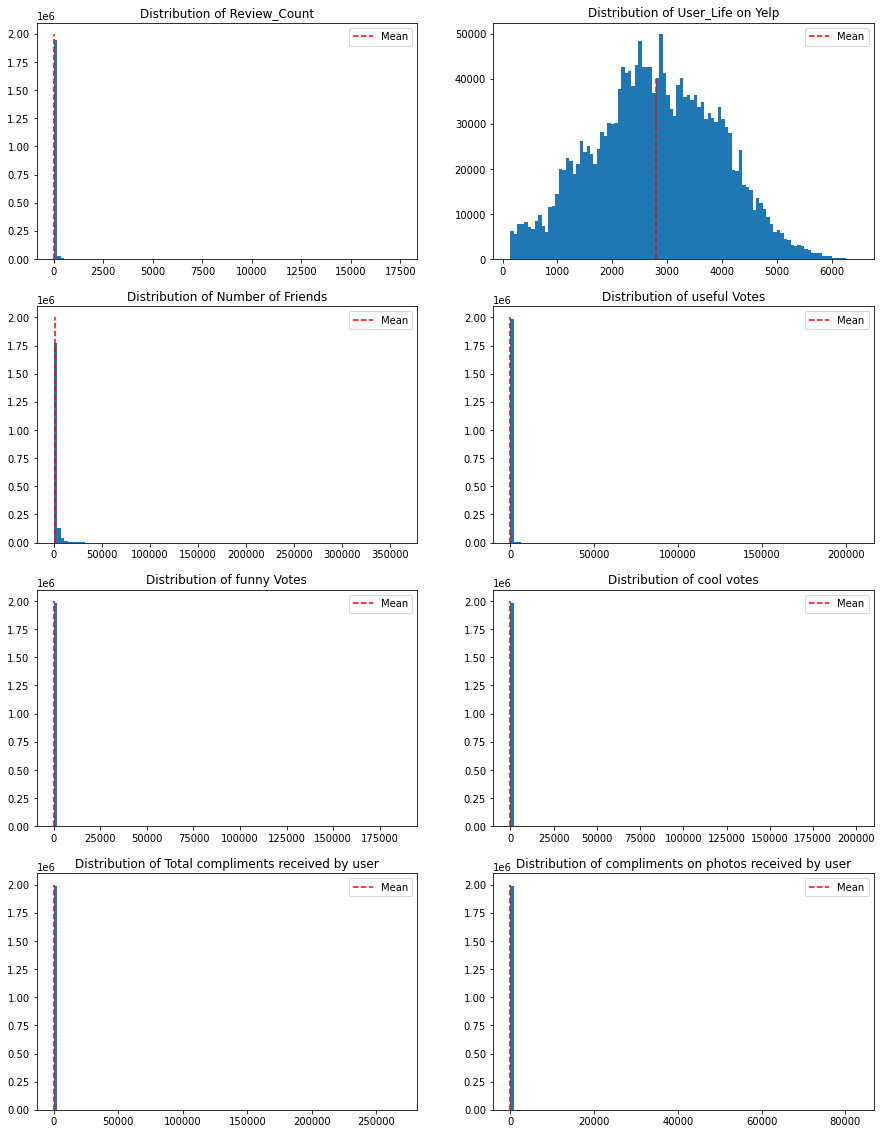

In [ ]:
#Plotting the distribution of various features using histograms with the most common response/ number of responses

fig , ax = plt.subplots(4,2 , figsize = (15,20))

ax[0][0].hist(user_df['review_count'].values , bins = 100)
ax[0][0].vlines(int(np.round(user_df['review_count'].mean())) , 0 , 2000000 , color = 'r' , linestyle = 'dashed' , label = 'Mean')
ax[0][0].set_title("Distribution of Review_Count")
ax[0][0].legend()

ax[0][1].hist(user_lifecycle_df['User_life'].values , bins = 100)
ax[0][1].vlines(int(np.round(user_lifecycle_df['User_life'].mean())) , 0 , 40000, color = 'r' , linestyle = 'dashed' , label = 'Mean')
ax[0][1].set_title("Distribution of User_Life on Yelp")
ax[0][1].legend()

ax[1][0].hist(friend_count['Number_of_friends'].values , bins = 100)
ax[1][0].vlines(int(np.round(friend_count['Number_of_friends'].mean())) , 0 , 2000000, color = 'r' , linestyle = 'dashed',label = 'Mean')
ax[1][0].set_title("Distribution of Number of Friends")
ax[1][0].legend()

ax[1][1].hist(votes_df['useful'].values , bins = 100)
ax[1][1].vlines(int(np.round(votes_df['useful'].mean())) , 0 ,2000000, color = 'r' , linestyle = 'dashed',label = 'Mean')
ax[1][1].set_title("Distribution of useful Votes")
ax[1][1].legend()

ax[2][0].hist(votes_df['funny'].values , bins = 100)
ax[2][0].vlines(int(np.round(votes_df['funny'].mean())) , 0 ,2000000, color = 'r' , linestyle = 'dashed',label = 'Mean')
ax[2][0].set_title("Distribution of funny Votes")
ax[2][0].legend()

ax[2][1].hist(votes_df['cool'].values , bins = 100)
ax[2][1].vlines(int(np.round(votes_df['cool'].mean())) , 0 ,2000000, color = 'r' , linestyle = 'dashed',label = 'Mean')
ax[2][1].set_title("Distribution of cool votes")
ax[2][1].legend()

ax[3][0].hist(comp_df['TOTAL'].values , bins = 100)
ax[3][0].vlines(int(np.round(comp_df['TOTAL'].mean())) , 0 ,2000000, color = 'r' , linestyle = 'dashed',label = 'Mean')
ax[3][0].set_title("Distribution of Total compliments received by user")
ax[3][0].legend()

ax[3][1].hist(comp_df['compliment_photos'].values , bins = 100)
ax[3][1].vlines(int(np.round(comp_df['compliment_photos'].mean())) , 0 ,2000000, color = 'r' , linestyle = 'dashed',label = 'Mean')
ax[3][1].set_title("Distribution of compliments on photos received by user")
ax[3][1].legend()


In [ ]:
# years the user was a elite user on the app 

query_7 = '''
    SELECT DISTINCT user_id , elite
    FROM user_sql

'''

elite = cursor.execute(query_7).fetchall()

In [ ]:
# store the result in a dataframe and sorting on elite
elite_df = pd.DataFrame(elite , columns = ['user_id','elite'])
elite_df.sort_values(by = 'elite',ascending = False)

,user_id,elite
618157,qh0dymU9ORy1ECCewHBzcQ,2021
300478,SYaP2pTaheR8j-pq9VdP9g,2021
41326,N5ek5cqxLhPlGLx6UPbXXA,2021
688164,dDUstIhusW3QlD_qizi1lw,2021
1628657,J6dYRAy8StI5qDt5QZVEpg,2021
...,...,...
698240,7uru0LN1WrvpOOIrMc5LMA,
698239,sV_I8W7y8qyqkmv1tdCcOw,
698238,FUppGits48JwdTIy9cLLJg,
698237,LXxf08mSHn2gn1Z-ZTjHCQ,


In [ ]:
# spitting the list of years into a list
elite_df['elite'] = elite_df['elite'].apply(lambda x : x.split(","))

In [ ]:
# one hot encoding the years
elite_df = elite_df.drop('elite', 1).join(elite_df.elite.str.join('|').str.get_dummies())

In [ ]:
# fixing bad data
elite_df['2020'] = elite_df['20']
elite_df.drop('20' , axis = 1 , inplace = True)

In [ ]:
elite_df.head()

,user_id,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2021,2020
0,qVc8ODYU5SZjKXVBgXdI7w,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,j14WgRoU_-2ZE1aw1dXrJg,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2WnXYQFK0hXEoTxPtV2zvg,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0
3,SZDeASXq7o05mMNLshsdIA,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0
4,hA5lMy-EnncsH4JoR-hFGQ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Taking the sum of number of times a user was elite on Yelp
elite_df['Total'] = elite_df.iloc[:,1:].sum(axis=1)

In [ ]:
# Sorting for the most elite users one yelp
elite_df = elite_df.sort_values(by = 'Total' , ascending = False)

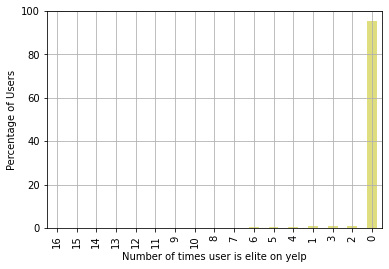

In [ ]:
# Plotting the percentage of elite users on yelp 
elite_df['Total'].value_counts().apply(lambda x : (x/len(elite_df))*100).sort_values(ascending = True).plot.bar(color = 'y' , alpha = 0.5)
plt.xlabel("Number of times user is elite on yelp")
plt.ylabel("Percentage of Users")
plt.grid()

In [ ]:
# defining the elite_per as percentage of elite users and non_elite as percentage of no elite users
elite_per = elite_df['Total'].value_counts().apply(lambda x : (x/len(elite_df))*100).sort_values(ascending = True)[:6].sum()
non_elite = elite_df['Total'].value_counts().apply(lambda x : (x/len(elite_df))*100).sort_values(ascending = True)[-1:].values[0]

In [ ]:
print("Only {}% of users were elite for more than 10 years".format(np.round(elite_per , 2)))
print("Around {}% of users were never elite on yelp in 15years".format(np.round(non_elite,2)))

Only 0.12% of users were elite for more than 10 years
Around 95.41% of users were never elite on yelp in 15years


In [ ]:
# choosing the dataframe of supreme elite users who have been elite for more than  years
elite_users = elite_df[elite_df['Total'] > 10]

In [ ]:
elite_users.head()

,user_id,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2021,2020,Total
796244,OnagJ2dnPjfRRT4a_CgKCw,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,16
2114,nnImk681KaRqUVHlSfZjGQ,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,16
994025,Nlfemj273YV_Ro3dwep8Kw,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,16
601978,PdpWp_j67Nfr_oQF-4yKUw,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,16
200145,DecNq9BYtMwHhgdnPNGbVQ,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,16


In [ ]:
# merging the data for different features on user_id of elite features
df_1 = pd.merge(elite_users , user_df)
df_1 = pd.merge(df_1 , user_lifecycle_df)
df_1 = pd.merge(df_1 , friend_count)
df_1 = pd.merge(df_1 , votes_df)
elite_df = pd.merge(df_1 , comp_df)

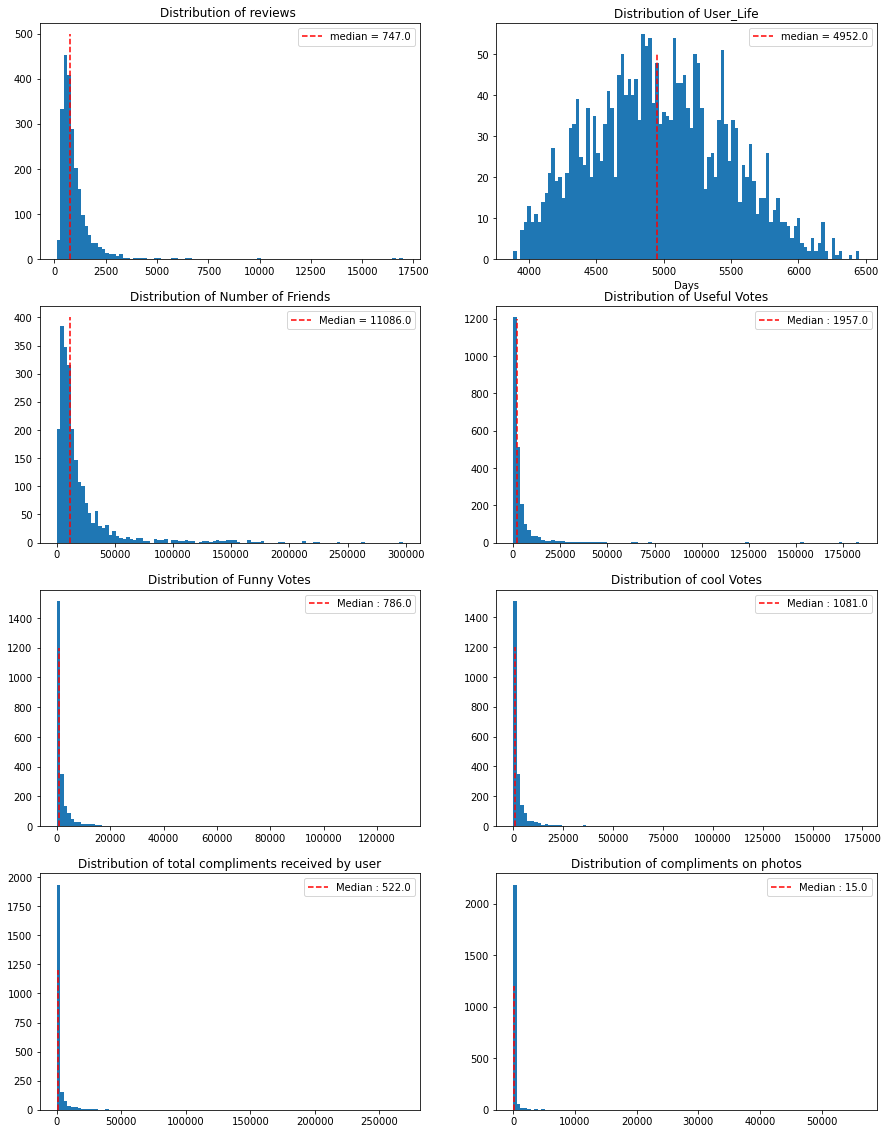

In [ ]:
# plotting the distribution of features for supreme elite users on yelp and their most common reponse/ number of number of responses
fig , ax = plt.subplots(4,2 ,figsize = (15,20))

ax[0][0].hist(elite_df['review_count'].values , bins = 100)
ax[0][0].vlines(elite_df['review_count'].median() , 0, 500 , color = 'r' , linestyle = 'dashed' , label = 'median = {}'.format(elite_df['review_count'].median()))
ax[0][0].set_title("Distribution of reviews ")
ax[0][0].legend()

ax[0][1].hist(elite_df['User_life'].values , bins = 100)
ax[0][1].vlines(elite_df['User_life'].median() , 0, 50 , color = 'r' , linestyle = 'dashed',label = 'median = {}'.format(elite_df['User_life'].median()))
ax[0][1].set_title("Distribution of User_Life")
ax[0][1].set_xlabel("Days")
ax[0][1].legend()

ax[1][0].hist(elite_df['Number_of_friends'].values , bins = 100)
ax[1][0].vlines(elite_df['Number_of_friends'].median() , 0, 400 , color = 'r' , linestyle = 'dashed' , label = 'Median = {}'.format(elite_df['Number_of_friends'].median()))
ax[1][0].set_title("Distribution of Number of Friends")
ax[1][0].legend()

ax[1][1].hist(elite_df['useful'].values , bins = 100)
ax[1][1].vlines(elite_df['useful'].median() , 0, 1200 , color = 'r' , linestyle = 'dashed' , label = 'Median : {}'.format(elite_df['useful'].median()))
ax[1][1].set_title("Distribution of Useful Votes")
ax[1][1].legend()

ax[2][0].hist(elite_df['funny'].values , bins = 100)
ax[2][0].vlines(elite_df['funny'].median() , 0, 1200 , color = 'r' , linestyle = 'dashed' , label = 'Median : {}'.format(elite_df['funny'].median()))
ax[2][0].set_title("Distribution of Funny Votes")
ax[2][0].legend()

ax[2][1].hist(elite_df['cool'].values , bins = 100)
ax[2][1].vlines(elite_df['cool'].median() , 0, 1200 , color = 'r' , linestyle = 'dashed' , label = 'Median : {}'.format(elite_df['cool'].median()))
ax[2][1].set_title("Distribution of cool Votes")
ax[2][1].legend()

ax[3][0].hist(elite_df['TOTAL'].values , bins = 100)
ax[3][0].vlines(elite_df['TOTAL'].median() , 0, 1200 , color = 'r' , linestyle = 'dashed' , label = 'Median : {}'.format(elite_df['TOTAL'].median()))
ax[3][0].set_title("Distribution of total compliments received by user")
ax[3][0].legend()

ax[3][1].hist(elite_df['compliment_photos'].values , bins = 100)
ax[3][1].vlines(elite_df['compliment_photos'].median() , 0, 1200 , color = 'r' , linestyle = 'dashed' , label = "Median : {}".format(elite_df['compliment_photos'].median()))
ax[3][1].set_title("Distribution of compliments on photos")
ax[3][1].legend()

In [ ]:
# querying for list of friends for each user id 
query_8 = '''
    SELECT DISTINCT user_id , friends
    FROM user_sql

'''

friends = cursor.execute(query_8).fetchall()

In [ ]:
# storing the result in a dataframe
friends_df = pd.DataFrame(friends , columns = ['user_id','friends'])

In [ ]:
# sorting the dataframe on number of friends 
elite_friends = pd.merge(elite_df , friends_df)[['user_id','friends','Number_of_friends']].sort_values(by = 'Number_of_friends' , ascending = False)

In [ ]:
# assigning a numeric user_id for each user_id string in a dictionary
user_dict = {}
for i in range(0,len(user_id)):
    user_dict[user_df.user_id[i]] = i

In [ ]:
# Creating a DataFrame of mutaul friends 
# This returns 4 lists, the user_id_1 , user_id_2 , mutual friends between two ids , number of mutual friends between two ids 
# stores 0 if there are no mutual friends

mutual = []                        #string id of mutual friend
mutual_nos = []                    # number of mutual friends
ui_1 = []                          # User_1 ID
ui_2 = []                          # User_2 ID 
for i in range(0,len(elite_friends)):
    for j in range(1 , len(elite_friends)):
        res_1 = elite_friends.friends[i].strip('][').split(', ')
        res_2 = elite_friends.friends[j].strip('][').split(', ')
        idx_1 = []
        idx_2 = []
    for k in res_1:
        if k in user_dict.keys():
            idx_1.append(k)
    for l in res_2:
        if l in user_dict.keys():
            idx_2.append(l)
    if len(set.intersection(set(idx_1) , set(idx_2))) != 0:
        ui_1.append(i)
        ui_2.append(j)
        mutual_nos.append(len(set.intersection(set(idx_1) , set(idx_2))))
        mutual.append(set.intersection(set(idx_1) , set(idx_2)))
    else:
        ui_1.append(i)
        ui_2.append(j)
        mutual_nos.append(0)
        mutual.append(0)

In [ ]:
mutual_df = pd.DataFrame()

In [ ]:
# creating dataframe of mutuals 
mutual_df['User_1'] = ui_1
mutual_df['User_2'] = ui_2

mutual_df['Mutuals'] = mutual
mutual_df['Number of Mutuals'] = mutual_nos

In [ ]:
# creating a function for getting key corresponding to a values from dictionary
def get_key(val):
    keys = user_dict.keys()
    for k in keys:
        if user_dict[k] == val:
            return k

In [ ]:
# converting the integer to string id for user_id
mutual_df['User_id_1'] = mutual_df['User_1'].apply(lambda x : get_key(x))
mutual_df['User_id_2'] = mutual_df['User_2'].apply(lambda x : get_key(x))

In [ ]:
# dropping the numeric id of user
mutual_df.drop(['User_1' , 'User_2' ], axis=1 , inplace = True)

In [ ]:
# viewing DataBase of mutual friends among elite users
mutual_df.head()

,Mutuals,Number of Mutuals,User_id_1,User_id_2
0,{OdMNiPACHRZc8FOr6IE1Bg},1,qVc8ODYU5SZjKXVBgXdI7w,IOyvme2n-lPfBT2lyb_Lsg
1,"{m7nSwHRMpGKQcB3dyqurZg, ZcFB7xOpJufgX9hHPFh9m...",11,j14WgRoU_-2ZE1aw1dXrJg,IOyvme2n-lPfBT2lyb_Lsg
2,"{dgrejzJzzI485oR3PHTfFw, ZcFB7xOpJufgX9hHPFh9m...",5,2WnXYQFK0hXEoTxPtV2zvg,IOyvme2n-lPfBT2lyb_Lsg
3,"{9aPhTC34PILldShZHzPi5g, uKxUtSvo1An9d1xbQOiid...",7,SZDeASXq7o05mMNLshsdIA,IOyvme2n-lPfBT2lyb_Lsg
4,{yLW8OrR8Ns4X1oXJmkKYgg},1,hA5lMy-EnncsH4JoR-hFGQ,IOyvme2n-lPfBT2lyb_Lsg


## Creating recommandation system

### creating business-business similaity matrix

In [ ]:
# sparse_data = csr_matrix((new_rec_df.Rest_Rating, (new_rec_df.user_id, new_rec_df.business_id)))
# Compute the cosine similarity
def cosine_similarity(ratings, epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    sim = np.dot(ratings.T,ratings)  + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim/(norms*norms.T))

In [ ]:
final_business_df = pd.read_sql("SELECT * FROM Business_sql", conn)

In [ ]:
final_business_df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,hours_Wednesday_opening,hours_Wednesday_closing,hours_Thursday_opening,hours_Thursday_closing,hours_Friday_opening,hours_Friday_closing,hours_Saturday_opening,hours_Saturday_closing,hours_Sunday_opening,hours_Sunday_closing
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,1900-01-01 07:00:00,1900-01-01 20:00:00,1900-01-01 07:00:00,1900-01-01 20:00:00,1900-01-01 07:00:00,1900-01-01 21:00:00,1900-01-01 07:00:00,1900-01-01 21:00:00,1900-01-01 07:00:00,1900-01-01 21:00:00
1,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,...,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 09:00:00,1900-01-01 00:00:00,1900-01-01 09:00:00,1900-01-01 22:00:00,1900-01-01 08:00:00,1900-01-01 22:00:00
2,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,...,1900-01-01 06:00:00,1900-01-01 21:00:00,1900-01-01 06:00:00,1900-01-01 16:00:00,1900-01-01 06:00:00,1900-01-01 16:00:00,1900-01-01 06:00:00,1900-01-01 17:00:00,1900-01-01 06:00:00,1900-01-01 21:00:00
3,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,...,1900-01-01 11:00:00,1900-01-01 14:00:00,1900-01-01 11:00:00,1900-01-01 14:00:00,1900-01-01 11:00:00,1900-01-01 14:00:00,1900-01-01 05:00:00,1900-01-01 10:00:00,1900-01-01 15:00:00,1900-01-01 18:00:00
4,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,...,1900-01-01 10:00:00,1900-01-01 20:00:00,1900-01-01 10:00:00,1900-01-01 20:00:00,1900-01-01 10:00:00,1900-01-01 20:00:00,1900-01-01 10:00:00,1900-01-01 20:00:00,1900-01-01 10:00:00,1900-01-01 20:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18934,8n93L-ilMAsvwUatarykSg,Kitchen Gia,3716 Spruce St,Philadelphia,PA,19104,39.951018,-75.198240,3.0,22,...,1900-01-01 09:00:00,1900-01-01 19:30:00,1900-01-01 09:00:00,1900-01-01 19:30:00,1900-01-01 09:00:00,1900-01-01 17:00:00,1900-01-01 11:00:00,1900-01-01 17:00:00,1900-01-01 11:00:00,1900-01-01 19:30:00
18935,2MAQeAqmD8enCT2ZYqUgIQ,The Melting Pot - Nashville,"166 2nd Ave N, Ste A",Nashville,TN,37201,36.163875,-86.776311,4.0,204,...,1900-01-01 16:00:00,1900-01-01 21:00:00,1900-01-01 16:00:00,1900-01-01 21:00:00,1900-01-01 16:00:00,1900-01-01 22:00:00,1900-01-01 15:00:00,1900-01-01 22:00:00,1900-01-01 12:00:00,1900-01-01 21:00:00
18936,l9eLGG9ZKpLJzboZq-9LRQ,Wawa,19 N Bishop Ave,Clifton Heights,PA,19018,39.925656,-75.310344,3.0,11,...,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00
18937,cM6V90ExQD6KMSU3rRB5ZA,Dutch Bros Coffee,1181 N Milwaukee St,Boise,ID,83704,43.615401,-116.284689,4.0,33,...,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00


In [ ]:
final_business_df.drop(final_business_df.dtypes[final_business_df.dtypes == 'object'].index, axis=1, inplace=True)
final_business_df.drop(['latitude', 'longitude'], axis=1, inplace=True)

day_cols = [col for col in final_business_df.columns if col.startswith('hours')]

In [ ]:
def cosine_similarity(ratings, epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    sim = np.dot(ratings.T, ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / (norms * norms.T))

item_item_sim = cosine_similarity(final_business_df.drop(day_cols, axis=1).T)

In [ ]:
business_ids = cursor.execute('SELECT DISTINCT(business_id) FROM business_sql').fetchall()
business_ids_mapping = {o[0]:i + 1 for i,o in enumerate(business_ids)}

In [ ]:
item_item_df = pd.DataFrame(item_item_sim,index = business_ids_mapping.keys())
item_item_df.columns = business_ids_mapping.keys()
item_item_df.head()

,MTSW4McQd7CbVtyjqoe9mw,CF33F8-E6oudUQ46HnavjQ,bBDDEgkFA1Otx9Lfe7BZUQ,eEOYSgkmpB90uNA7lDOMRA,0bPLkL0QhhPO5kt1_EXmNQ,WKMJwqnfZKsAae75RMP6jA,aPNXGTDkf-4bjhyMBQxqpQ,ljxNT9p0y7YMPx0fcNBGig,lk9IwjZXqUMqqOhM774DtQ,cVBxfMC4lp3DnocjYA3FHQ,...,Y5gyxnQt44B3axgzrjttlw,uriD7RFuHhLJeDdKaf0nFA,Wko0HNelt55ZIp3Dm3eD2g,wVxXRFf10zTTAs11nr4xeA,sf_oQ62L8UEnOOLf00nNGA,8n93L-ilMAsvwUatarykSg,2MAQeAqmD8enCT2ZYqUgIQ,l9eLGG9ZKpLJzboZq-9LRQ,cM6V90ExQD6KMSU3rRB5ZA,2O2K6SXPWv56amqxCECd4w
MTSW4McQd7CbVtyjqoe9mw,1.000000,0.835344,0.941373,0.938379,0.999190,0.995396,0.998371,0.998676,0.998866,0.971571,...,0.810444,0.998794,0.750801,0.997732,0.873409,0.983264,0.998936,0.952687,0.992563,0.951023
CF33F8-E6oudUQ46HnavjQ,0.835344,1.000000,0.950701,0.864393,0.840830,0.852504,0.847266,0.839446,0.829563,0.879820,...,0.830915,0.824969,0.862000,0.851871,0.904515,0.892701,0.826723,0.891978,0.866886,0.888581
bBDDEgkFA1Otx9Lfe7BZUQ,0.941373,0.950701,1.000000,0.917534,0.944454,0.943357,0.948859,0.943005,0.939131,0.947971,...,0.831971,0.935967,0.848187,0.949659,0.915544,0.968196,0.936922,0.947563,0.955549,0.941837
eEOYSgkmpB90uNA7lDOMRA,0.938379,0.864393,0.917534,1.000000,0.935451,0.948255,0.938796,0.931463,0.927979,0.969926,...,0.944804,0.925304,0.861437,0.937695,0.950379,0.946647,0.927294,0.963884,0.955361,0.981401
0bPLkL0QhhPO5kt1_EXmNQ,0.999190,0.840830,0.944454,0.935451,1.000000,0.994840,0.998624,0.999030,0.999179,0.969719,...,0.805632,0.999048,0.749770,0.998426,0.871698,0.983768,0.998974,0.952109,0.992625,0.948588


In [ ]:
user_ids = cursor.execute('SELECT DISTINCT(user_id) FROM user_sql').fetchall()
user_ids_mapping = {o[0]:i+1 for i,o in enumerate(user_ids)}

### creating CF based on latent factors decomposition using SGD

In [ ]:
ratings = pd.read_sql('''SELECT  a.business_id, b.user_id, b.stars AS user_rating
        FROM business_sql AS a INNER JOIN review_sql AS b
        ON a.business_id = b.business_id''', conn)

In [ ]:
ratings.head()

,business_id,user_id,user_rating
0,MTSW4McQd7CbVtyjqoe9mw,-6GY04bTPM2Zo4z0GN4a1A,5
1,MTSW4McQd7CbVtyjqoe9mw,-ZskOdnpNCWzTjeoBQM1LA,3
2,MTSW4McQd7CbVtyjqoe9mw,0_FWb5d-EkJVaP0GAr0gcQ,4
3,MTSW4McQd7CbVtyjqoe9mw,0_FWb5d-EkJVaP0GAr0gcQ,4
4,MTSW4McQd7CbVtyjqoe9mw,0q2W3-ieBUJWD5TTLKi3Ug,4


In [ ]:
ratings.shape

(1649541, 3)

In [ ]:
ratings['user_id'] = ratings['user_id'].map(user_ids_mapping)
ratings['business_id'] = ratings['business_id'].map(business_ids_mapping)
ratings.head()

,business_id,user_id,user_rating
0,1,497965.0,5
1,1,90161.0,3
2,1,14037.0,4
3,1,14037.0,4
4,1,80103.0,4


In [ ]:
ratings.isna().sum()

business_id    0
user_id        1
user_rating    0
dtype: int64

In [ ]:
ratings.dropna(axis=0, inplace=True)
ratings.isna().sum()

business_id    0
user_id        0
user_rating    0
dtype: int64

In [ ]:
ratings['user_id'] = ratings['user_id'].astype(int)

In [ ]:
n_business = len(ratings['business_id'].unique())
n_users = len(ratings['user_id'].unique())

In [ ]:
#custom sigmoid function to clip the prediction between 0 and 5
def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low
    return custom_sigmoid
sm = sigmoid_maker(0, 5)

## Model with optimizatoin on residuals

In [ ]:
train_idx, test_idx = train_test_split(range(ratings.shape[0]), test_size=0.3, random_state=10)
trdf = ratings.iloc[train_idx]
testdf = ratings.iloc[test_idx]
trdf.shape, testdf.shape

((1154678, 3), (494862, 3))

In [ ]:
#getting constant values now we'll try to fit on residuals and see the mse
n_latent_factors = 50
reg = 5e-4

# business embeddings
business_input = keras.layers.Input(shape=[1],name='business')
business_embedding = keras.layers.Embedding(n_business, n_latent_factors, input_length=1, name='Business_Embedding', embeddings_regularizer=l2(reg))(business_input)
#adding a bias layer
business_bias = keras.layers.Embedding(n_business, 1, input_length=1, name='Business_bias')(business_input)
business_bias_flat = keras.layers.Flatten(name='Business_bias_flat')(business_bias)

# user embeddings
user_input = keras.layers.Input(shape=[1],name='user')
user_embedding = keras.layers.Embedding(n_users, n_latent_factors, input_length=1, name='User_Embedding', embeddings_regularizer=l2(reg))(user_input)
#adding a bias layer
user_bias = keras.layers.Embedding(n_users, 1, input_length=1, name='User_bias')(user_input)
user_bias_flat = keras.layers.Flatten(name='Users_bias_flat')(user_bias)

residual = keras.layers.Dot(axes=2,name='Residual')([user_embedding, business_embedding])
residflat = keras.layers.Flatten(name="residual_flat")(residual)
regression = keras.layers.Add(name="regression")([user_bias_flat, business_bias_flat, residflat])
output = keras.layers.Activation(sm, name='sigmoid_custom')(regression)
model = keras.Model([user_input, business_input], output)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 business (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 50)        36336900    ['user[0][0]']                   
                                                                                                  
 Business_Embedding (Embedding)  (None, 1, 50)       946950      ['business[0][0]']               
                                                                                            

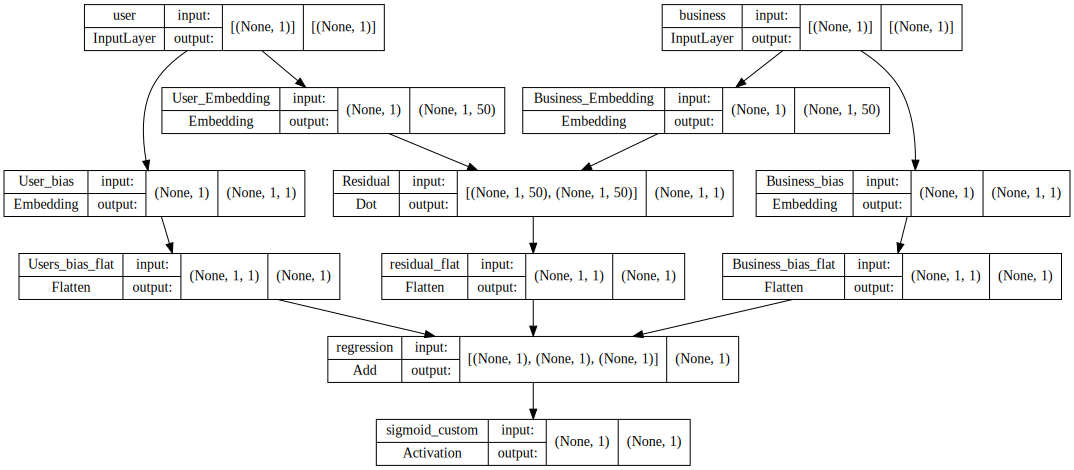

In [ ]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, dpi=72, rankdir='TB').create_svg())

In [ ]:
%mkdir model2_data

In [ ]:
model.compile(optimizer='sgd', loss='mean_squared_error', metrics=['mae', 'mse'])

In [ ]:
es = keras.callbacks.EarlyStopping('val_loss', patience=4, verbose=1, restore_best_weights=True)
mc = keras.callbacks.ModelCheckpoint('model2_data', verbose=1)

In [ ]:
history = model.fit([trdf['user_id'], trdf['business_id']], trdf['user_rating'], callbacks=[es, mc], epochs=10, batch_size=64,
                    validation_data=([testdf['user_id'], testdf['business_id']], testdf['user_rating']))

Epoch 1/10
18040/18042 [============================>.] - ETA: 0s - loss: 16.4143 - mae: 1.6829 - mse: 3.3760
Epoch 1: saving model to model2_data
INFO:tensorflow:Assets written to: model2_data/assets
18042/18042 [==============================] - 361s 20ms/step - loss: 16.4141 - mae: 1.6829 - mse: 3.3760 - val_loss: 13.9590 - val_mae: 1.6149 - val_mse: 3.1322
Epoch 2/10
 8799/18042 [=============>................] - ETA: 2:23 - loss: 12.9692 - mae: 1.5879 - mse: 3.0413

In [ ]:
model_history = history.history
plt.plot([f"epoch {i+1}" for i in range(len(model_history['val_loss']))], model_history['val_loss'])
plt.xlabel('epoch')
plt.xticks(rotation=45)
plt.ylabel('Validation loss')
plt.title('Model loss with each epoch')
plt.show()

In [ ]:
dfpreds = testdf[['business_id', 'user_id', 'user_rating']].copy()
dfpreds['predictions'] = model.predict([dfpreds['user_id'], dfpreds['business_id']]).ravel()